# IMPORTATION DES VARIABLES

In [130]:

# import pandas as pd
import numpy as np
import seaborn as snss
import glob

# Les packages de visualisation des données de notre dataset
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# packages permettant de faire la classification
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Packages de classification pour faire des estimations
from sklearn.neighbors import KNeighborsClassifier

from rich import print
from openpyxl import load_workbook
import folium as fl
import scipy.stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# DEFINITION DES FONCTIONS ET PROCEDURES

In [161]:
def fichiers_excel(dossier):
    # Get a list of all excel files in the provided folder
    excel_files = glob.glob(f'{dossier}/*.xlsx')
    file_names = [file.split('\\')[-1].split('.')[0] for file in excel_files]
    file_dict = {name: file for name, file in zip(file_names, excel_files)}
    return file_dict

def feuilles_fichier(fichier):
    """
    Retourne une liste des noms de feuilles d'un fichier Excel.
    :param excel_file_path: Le chemin complet vers le fichier Excel
    :type excel_file_path: str
    :return: Une liste contenant les noms de toutes les feuilles du fichier Excel
    :rtype: list
    """
    try:
        # Charger le workbook
        workbook = load_workbook(fichier, read_only=True)
        
        # Obtenir les noms des feuilles
        sheet_names = workbook.sheetnames
        
        # Fermer le workbook pour libérer les ressources
        workbook.close()
        
        return sheet_names
    
    except FileNotFoundError:
        print(f"Erreur : Le fichier '{fichier}' n'a pas été trouvé.")
        return []
    
    except Exception as e:
        print(f"Une erreur s'est produite lors de la lecture du fichier Excel : {str(e)}")
        return []
def lire_feuille_fichier(file,sheet):
    # Load the first sheet from the first excel file into a pandas dataframe
    df = pd.read_excel(file, sheet_name=sheet)
    return df


def fusion_colonnes_dfs(*dataframes):
    """
    Fusionne toutes les colonnes présentes dans les DataFrames fournis.
    :param dataframes: Un nombre variable de DataFrames pandas
    :return: Un nouveau DataFrame contenant toutes les colonnes des DataFrames d'entrée
    """
    # Vérifier qu'au moins un DataFrame a été fourni
    if len(dataframes) == 0:
        raise ValueError("Au moins un DataFrame doit être fourni.")
    # Créer une liste pour stocker tous les DataFrames
    all_dfs = []
    for df in dataframes:
        # Vérifier que l'argument est bien un DataFrame
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"Tous les arguments doivent être des DataFrames. Reçu: {type(df)}")
        # Réinitialiser l'index pour éviter les conflits lors de la fusion
        df_reset = df.reset_index(drop=True)
        all_dfs.append(df_reset)
    # Utiliser pd.concat pour fusionner tous les DataFrames
    # axis=1 signifie que nous fusionnons horizontalement (par colonnes)
    merged_df = pd.concat(all_dfs)
    # Supprimer les doublons de colonnes si nécessaire
    merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
    return merged_df

def fusion_dfs(list):
    """
    Fusionne toutes les DataFrames fournis dans une liste.
    :param list: Une liste de DataFrames pandas
    :return: Un nouveau DataFrame contenant toutes les colonnes des DataFrames d'entrée
    """
    # Vérifier qu'au moins un DataFrame a été fourni
    if len(list) == 0:
        raise ValueError("Au moins un DataFrame doit être fourni.")
    # Créer une liste pour stocker tous les DataFrames
    all_dfs = []
    for df in list:
        # Vérifier que l'argument est bien un DataFrame
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"Tous les arguments doivent être des DataFrames. Reçu: {type(df)}")
        else:
            pass
    fusion=pd.concat(list,ignore_index=True)
    return fusion

import pandas as pd

def dms_to_decimal(degrees, minutes, seconds, direction):
    """
    Convert DMS (Degrees, Minutes, Seconds) to decimal degrees.
    """
    decimal = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        decimal = -decimal
    return decimal

def convert_dms_to_decimal(df, lat_col, lon_col):
    """
    Convert DMS coordinates to decimal coordinates in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing DMS coordinates.
    lat_col (str): Name of the latitude column.
    lon_col (str): Name of the longitude column.
    
    Returns:
    pd.DataFrame: DataFrame with new decimal coordinates columns 'lat_decimal' and 'lon_decimal'.
    """
    def parse_dms(dms):
        # degrees = float(parts[0].replace('°', ''))
        # minutes = float(parts[1].replace('\'', ''))
        # seconds = float(parts[2].replace('"', ''))
        # direction = parts[3]
        degrees = float(dms.split('°')[0])
        rest=dms.split('°')[1]
        minutes = float(rest.split('\'')[0])
        rest=dms.split('\'')[1]
        seconds = float(rest.split('"')[0])
        direction = dms.split('"')[1]
        return degrees, minutes, seconds, direction

    df['y'] = df[lat_col].apply(lambda x: dms_to_decimal(*parse_dms(x)))
    df['x'] = df[lon_col].apply(lambda x: dms_to_decimal(*parse_dms(x)))

    return df
def convert_columns_to_float(df, columns):
    """
    Convert specified columns in a DataFrame to float values.
    
    Parameters:
    df (pd.DataFrame): DataFrame to convert.
    columns (list): List of column names to convert.
    
    Returns:
    pd.DataFrame: DataFrame with specified columns converted to float values.
    """
    df[columns] = df[columns].astype(float)
    return df

def render_interactive_map(dataframe, x_column, y_column):
    # Create a map centered at the mean of x and y coordinates
    map_center = [dataframe[y_column].mean(), dataframe[x_column].mean()]
    m = fl.Map(location=map_center, zoom_start=10)

    # Add markers for each data point
    for index, row in dataframe.iterrows():
        fl.Marker([row[y_column], row[x_column]]).add_to(m)

    # Display the map
    return m

def encode_var(dataframe,colonne):
    """Cette fonction nous permet d'encoder des valeurs qualitative d'une colonnes données en valeurs quantitatives numérique

    Args:
        dataframe (dataframe): Dataframe dans laquelle nous voulons raemplacer des valeurs de colonnnes
        colonne (char): nom de la colonnes à encoder

    Returns:
        dataframe: dataframe de la nouvelle colonne encodée
    """
    unique=list(dataframe[colonne].unique())
    encoding=list(range(len(unique)))
    return {"df":dataframe[colonne].replace(unique, encoding) , "encodage":dict(zip(unique, encoding))}

def new_merged_df(dataframe,cols):
    """
    Une fonction python qui permet de restructurer les données de destinations suivant leurs origines 

    Args:
        dataframe (dataframe): dataframe à modifier
        cols (liste): liste des colonnes à dupliquer 

    Returns:
        dataframe: dataframe restructurée
    """
    list_dfs=[]
    for x in cols:
        print(x)
        dataframe["destination"]=dataframe[x]
        print(dataframe["destination"])
        dataframe["source"]=x
        # print(dataframe["source"])
        list_dfs.append(dataframe.copy(deep=True))
        
    merged_df=pd.concat(list_dfs,ignore_index=True)
    merged_df.drop(columns=cols)
    return merged_df


def new_merged_df1(dataframe,cols):
    """Une fonction qui permet de restructurer les données des utilisations suivant leurs origines

    Args:
        dataframe (dataframe): Dataframe à modifier
        cols (list): Liste des colonnes à dupliquer
        
    Returns:
        dataframe: dataframe restructurée
    """
    list_dfs1=[]
    for y in cols:
        print(y)
        dataframe['utilisation']=dataframe[y]
        print(dataframe['utilisation'])
        dataframe['Origine']=y
        list_dfs1.append(dataframe.copy(deep=True))
        
    merged_df1=pd.concat(list_dfs1,ignore_index=True)
    merged_df1.drop(columns=cols)
    return merged_df1

# INITIALISATION DES VARIABLES

In [79]:
dossier= 'DB'

In [ ]:
fichiers=fichiers_excel(dossier)
print(f"Liste des feuilles excel de base de données dans le dossier : \n {fichiers}")

# Affichage des feuilles de calcul dans un excel file
for file in fichiers:
    print(f"Feuilles de calcul dans {file}:\n", feuilles_fichier(fichiers[file]))
    

## Importation des données des feuilles UT; UC et UP de Bouaké

In [46]:
UT_bouake=lire_feuille_fichier(fichiers["bouake"],"UT")
UC_bouake=lire_feuille_fichier(fichiers["bouake"],"UC")
UP_bouake=lire_feuille_fichier(fichiers["bouake"],"UP")

## Fusion des dataframes des unités de Bouaké

In [ ]:
df_bouake=fusion_dfs([UT_bouake,UC_bouake,UP_bouake])
df_bouake.head()

In [58]:
df_bouake.to_excel("bouake_fusion.xlsx")

In [ ]:
df_bouake.info()

## Importation des données des feuilles UT; UC et UP de Korhogo

In [81]:
UT_korhogo=lire_feuille_fichier(fichiers["korhogo"],"UT")
UC_korhogo=lire_feuille_fichier(fichiers["korhogo"],"UC")
UP_korhogo=lire_feuille_fichier(fichiers["korhogo"],"UP")

## Fusion des dataframes des unités de Bouaké

In [83]:
df_korhogo=fusion_dfs([UT_korhogo,UC_korhogo,UP_korhogo])

In [84]:
df_korhogo.to_excel("korhogo_fusion.xlsx")

# Importation des données de base coordonnées de yamoussoukro

In [ ]:
data_yakro= lire_feuille_fichier(fichiers["yakro_coord"],"data")
# feuilles_fichier(fichiers["yakro_coord"])
df_yakro=convert_dms_to_decimal(data_yakro,'lat_dms', 'lon_dms')
print(data_yakro.columns)

In [36]:
df_yakro.to_excel("yakro_coordonnees.xlsx")

In [ ]:
render_interactive_map(df_bouake,"Y","X")

# Du machine learning

## pour bouaké

### Les destinations

In [ ]:
# initiation de df
df = pd.DataFrame(df_bouake)

# génération de 4 colonnes Dest1 à Dest4 à dupliquer
cols_to_duplicate = ["Dest{}".format(x+1) for x in range(4)]

# une nouvelle dataframe contenant les valeurs de df et les valeurs des colonnes dupliquées
new_df_bouake = new_merged_df(df,cols_to_duplicate)

# une nouvelle dataframe contenant les valeurs concaténées de df et de new_df
df_bouake = pd.concat([df,new_df_bouake], ignore_index=True)

In [ ]:
# df_cleaned est obtenue en supprimant toutes les valeurs manquantes dans dans la colonne destination de new_df_bouake
df_cleaned = df_bouake.dropna(subset='destination')

In [61]:
# création d'un fichier excel après suppression des valeurs manquantes dans la colonne destination
df_cleaned.to_excel("DB\\df_cleaned_bouake.xlsx")

### Les usages ou utilisations

In [62]:
df_cleaned_bouake = lire_feuille_fichier(fichiers['df_cleaned_bouake'],"cleaned_b")

In [ ]:
df1=df_cleaned_bouake

# initiation de df2
df2 = pd.DataFrame(df1)

# génération de 4 colonnes Utilt1 à Util4 à dupliquer
cols_to_duplicate1 = ["Util{}".format(y+1) for y in range(3)]

# une nouvelle dataframe contenant les valeurs de df et les valeurs des colonnes dupliquées
new_df_bouake1 = new_merged_df1(df1,cols_to_duplicate1)

# une nouvelle dataframe contenant les valeurs concaténées de df et de new_df
df_bouake1 = pd.concat([df2,new_df_bouake1], ignore_index=True)
df_bouake1

In [ ]:
# df_bouake1.to_excel("DB\\concat_DU_bouake.xlsx")

In [64]:
# df_cleaned est obtenue en supprimant toutes les valeurs manquantes dans dans la colonne destination de new_df_bouake
df_cleaned1 = df_bouake1.dropna(subset='utilisation')
df_cleaned1.to_excel("DB\\df_cleaned_DU_bouake.xlsx")

In [ ]:
df_bouake = lire_feuille_fichier(fichiers['df_cleaned_DU_bouake'],'clean_du_b')
df_bouake

### L'encodage

In [66]:
# Supposons que vous ayez déjà exécuté les lignes de code pour obtenir les dictionnaires d'encodage
# et que vous les ayez stockés dans des variables :
encodage_destination = encode_var(df_bouake, "destination")['encodage']
encodage_utilisation = encode_var(df_bouake, 'utilisation')['encodage']
encodage_localprod = encode_var(df_bouake, 'Localisation_producteur')['encodage']
encodage_origine = encode_var(df_bouake, 'Origine')['encodage']
encodage_source = encode_var(df_bouake, 'source')['encodage']
encodage_type = encode_var(df_bouake, 'Type')['encodage']
encodage_pro = encode_var(df_bouake, 'PRO')['encodage']
encodage_secteur_activite = encode_var(df_bouake,'Secteur_activite')['encodage']

# ... et ainsi de suite pour les autres colonnes

# Fonction de mapping
def mapper(value, encoding_dict):
    return encoding_dict.get(value, value)  # Si la valeur n'est pas trouvée, on la garde telle quelle

# Application de l'encodage à toutes les colonnes
df_bouake['destination'] = df_bouake['destination'].map(lambda x: mapper(x, encodage_destination))
df_bouake['utilisation'] = df_bouake['utilisation'].map(lambda x: mapper(x, encodage_utilisation))
df_bouake['Localisation_producteur'] = df_bouake['Localisation_producteur'].map(lambda x: mapper(x, encodage_localprod))
df_bouake['Origine'] = df_bouake['Origine'].map(lambda x: mapper(x, encodage_origine))
df_bouake['source'] = df_bouake['source'].map(lambda x: mapper(x, encodage_source))
df_bouake['Type'] = df_bouake['Type'].map(lambda x: mapper(x, encodage_type))
df_bouake['PRO'] = df_bouake['PRO'].map(lambda x: mapper(x, encodage_pro))
df_bouake['Secteur_activite'] = df_bouake['Secteur_activite'].map(lambda x: mapper(x, encodage_secteur_activite))
df_bouake.to_excel('DB\\df_encode_bouake.xlsx')

## Pour korhogo

### Les destinations

In [ ]:
# initiation de df
df = pd.DataFrame(df_korhogo)

# génération de 4 colonnes Dest1 à Dest4 à dupliquer
cols_to_duplicate = ["Dest{}".format(x+1) for x in range(4)]

# une nouvelle dataframe contenant les valeurs de df et les valeurs des colonnes dupliquées
new_df_korhogo = new_merged_df(df,cols_to_duplicate)

# une nouvelle dataframe contenant les valeurs concaténées de df et de new_df
df_korhogo = pd.concat([df,new_df_korhogo], ignore_index=True)
df_korhogo

In [ ]:
# df_cleaned est obtenue en supprimant toutes les valeurs manquantes dans dans la colonne destination de new_df_bouake
df_cleaned = df_korhogo.dropna(subset='destination')
df_cleaned

In [97]:
# création d'un fichier excel après suppression des valeurs manquantes dans la colonne destination
df_cleaned.to_excel("DB\\df_cleaned_korhogo.xlsx")

### Pour les utilisations ou les usages

In [ ]:
df1 = lire_feuille_fichier(fichiers['df_cleaned_korhogo'],'cleaned_k')
# initiation de df
df2 = pd.DataFrame(df1)

# génération de 4 colonnes Utilt1 à Util4 à dupliquer
cols_to_duplicate1 = ["Util{}".format(y+1) for y in range(3)]

# une nouvelle dataframe contenant les valeurs de df et les valeurs des colonnes dupliquées
new_df_korhogo1 = new_merged_df1(df1,cols_to_duplicate1)

# une nouvelle dataframe contenant les valeurs concaténées de df et de new_df
df_korhog1 = pd.concat([df2,new_df_korhogo1], ignore_index=True)
df_korhog1

In [102]:
# df_cleaned est obtenue en supprimant toutes les valeurs manquantes dans dans la colonne destination de new_df_bouake
df_cleaned1 = df_korhog1.dropna(subset='utilisation')
df_cleaned1.to_excel("DB\\df_cleaned_DU_korhogo.xlsx")

In [ ]:
df_korhogo = lire_feuille_fichier(fichiers['df_cleaned_DU_korhogo'],'clean_du_k')
df_korhogo

In [194]:
df_korhogo.to_excel('DB\\verife.xlsx')

### L'encodage

In [108]:
# Supposons que vous ayez déjà exécuté les lignes de code pour obtenir les dictionnaires d'encodage
# et que vous les ayez stockés dans des variables :
encodage_destination = encode_var(df_korhogo, "destination")['encodage']
encodage_utilisation = encode_var(df_korhogo, 'utilisation')['encodage']
encodage_localprod = encode_var(df_korhogo, 'Localisation_producteur')['encodage']
encodage_origine = encode_var(df_korhogo, 'Origine')['encodage']
encodage_source = encode_var(df_korhogo, 'source')['encodage']
encodage_type = encode_var(df_korhogo, 'Type')['encodage']
encodage_pro = encode_var(df_korhogo, 'PRO')['encodage']
encodage_secteur_activite = encode_var(df_korhogo,'Secteur_activite')['encodage']

# ... et ainsi de suite pour les autres colonnes

# Fonction de mapping
def mapper(value, encoding_dict):
    return encoding_dict.get(value, value)  # Si la valeur n'est pas trouvée, on la garde telle quelle

# Application de l'encodage à toutes les colonnes
df_bouake['destination'] = df_bouake['destination'].map(lambda x: mapper(x, encodage_destination))
df_bouake['utilisation'] = df_bouake['utilisation'].map(lambda x: mapper(x, encodage_utilisation))
df_bouake['Localisation_producteur'] = df_bouake['Localisation_producteur'].map(lambda x: mapper(x, encodage_localprod))
df_bouake['Origine'] = df_bouake['Origine'].map(lambda x: mapper(x, encodage_origine))
df_bouake['source'] = df_bouake['source'].map(lambda x: mapper(x, encodage_source))
df_bouake['Type'] = df_bouake['Type'].map(lambda x: mapper(x, encodage_type))
df_bouake['PRO'] = df_bouake['PRO'].map(lambda x: mapper(x, encodage_pro))
df_bouake['Secteur_activite'] = df_bouake['Secteur_activite'].map(lambda x: mapper(x, encodage_secteur_activite))
df_bouake.to_excel('DB\\df_encode_korhogo.xlsx')

## Fusion des données de korhogo et de bouaké

In [123]:
# initiation des données de bouake et de korhogo pour faire la fusion des données
#   pour bouake
df_bouake=lire_feuille_fichier(fichiers['df_encode_bouake'],'encode_b')
#   pour korhogo
df_korhogo=lire_feuille_fichier(fichiers['df_encode_korhogo'],'encode_k')

In [124]:
# La fusion des données de yakro et celles de krhogo
df_bouake_korhogo =fusion_dfs([df_bouake,df_korhogo])
df_bouake_korhogo.to_excel('DB\\bouake_korhogo.xlsx')

## Application du scikit learning

In [167]:
# initiation: dfs exprime ici la dataframe de toutes les dataframes utilisées (bouaké, korhogo)
dfs = lire_feuille_fichier(fichiers['bouake_korhogo'],'bk')

### Lazypredict

In [ ]:
# # Lazypredict est un racourci pour la modélisation prédictive
# from lazypredict.Supervised import LazyClassifier
# from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split
# target = 'utilisation'
# x = dfs.loc[:, dfs.columns != target]
# y = dfs.loc[:, dfs.columns == target]
# # X = dfs.data
# # y= dfs.target

# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state =900)

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# print(models)

In [206]:
from sklearn.impute import KNNImputer

# Initialisation de l'imputateur KNN
imputer = KNNImputer(n_neighbors=2)

# Appliquer l'imputateur sur les données (en supposant qu'elles sont toutes numériques)
bouake_korhogo_imputed = pd.DataFrame(imputer.fit_transform(dfs), columns=dfs.columns)
bouake_korhogo_imputed.to_excel('DB\\b_k_imputed.xlsx')

In [216]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

# Charger les données depuis votre base de données bouake_korhogo
# Supposons que votre base de données est stockée dans un fichier CSV
# et que vous lisez les données dans un DataFrame
data = lire_feuille_fichier(fichiers['b_k_imputed'],'bki')

# Supposons que vos caractéristiques sont dans les colonnes de 0 à -2 et les étiquettes dans la dernière colonne
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Afficher les dimensions initiales
print(f'Dimensions de X: {X.shape}')
print(f'Dimensions de y: {y.shape}')

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Vérifier les dimensions après le découpage
print(f'Dimensions de X_train: {X_train.shape}')
print(f'Dimensions de y_train: {y_train.shape}')

# Initialiser LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Vérifier et corriger les dimensions si nécessaire
if len(X_train) != len(y_train):
    min_len = min(len(X_train), len(y_train))
    X_train = X_train[:min_len]
    y_train = y_train[:min_len]

# Réessayer avec les données corrigées
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Afficher les résultats
print(models)

Dimensions de X: (1294, 20)

Dimensions de y: (1294,)

Dimensions de X_train: (1035, 20)

Dimensions de y_train: (1035,)

 97%|█████████▋| 30/31 [00:02<00:00, 12.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 1035, number of used features: 19
[LightGBM] [Info] Start training from score -1.053279
[LightGBM] [Info] Start training from score -1.231730
[LightGBM] [Info] Start training from score -1.023263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 31/31 [00:02<00:00, 10.39it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             1.00               1.00    None      1.00   
XGBClassifier                      1.00               1.00    None      1.00   
LGBMClassifier                     1.00               1.00    None      1.00   
DecisionTreeClassifier             1.00               1.00    None      1.00   
BaggingClassifier                  1.00               1.00    None      1.00   
ExtraTreesClassifier               0.99               0.99    None      0.99   
ExtraTreeClassifier                0.88               0.88    None      0.88   
LabelSpreading                     0.79               0.78    None      0.79   
LabelPropagation                   0.79               0.78    None      0.79   
KNeighborsClassifier               0.78               0.77    None      0.78   
NuSVC                              0.70               0.69    None      0.70   
SVC                                0.69               0.67    None      0.68   
AdaBoostClassifier                 0.66               0.62    None      0.65   
LinearDiscriminantAnalysis         0.58               0.57    None      0.58   
LinearSVC                          0.58               0.56    None      0.57   
CalibratedClassifierCV             0.57               0.56    None      0.56   
RidgeClassifier                    0.55               0.54    None      0.55   
RidgeClassifierCV                  0.55               0.54    None      0.55   
LogisticRegression                 0.55               0.53    None      0.54   
PassiveAggressiveClassifier        0.51               0.51    None      0.51   
NearestCentroid                    0.52               0.51    None      0.51   
SGDClassifier                      0.50               0.50    None      0.50   
Perceptron                         0.43               0.44    None      0.43   
BernoulliNB                        0.42               0.40    None      0.41   
GaussianNB                         0.44               0.37    None      0.32   
QuadraticDiscriminantAnalysis      0.44               0.37    None      0.30   
DummyClassifier                    0.40               0.33    None      0.23   

                               Time Taken  
Model                                      
RandomForestClassifier               0.40  
XGBClassifier                        0.26  
LGBMClassifier                       0.43  
DecisionTreeClassifier               0.01  
BaggingClassifier                    0.08  
ExtraTreesClassifier                 0.27  
ExtraTreeClassifier                  0.03  
LabelSpreading                       0.10  
LabelPropagation                     0.11  
KNeighborsClassifier                 0.04  
NuSVC                                0.20  
SVC                                  0.12  
AdaBoostClassifier                   0.28  
LinearDiscriminantAnalysis           0.03  
LinearSVC                            0.04  
CalibratedClassifierCV               0.25  
RidgeClassifier                      0.02  
RidgeClassifierCV                    0.04  
LogisticRegression                   0.05  
PassiveAggressiveClassifier          0.03  
NearestCentroid                      0.03  
SGDClassifier                        0.02  
Perceptron                           0.03  
BernoulliNB                          0.05  
GaussianNB                           0.02  
QuadraticDiscriminantAnalysis        0.00  
DummyClassifier                      0.03

# Nous allons entrainer notre modèle

In [ ]:
# avec la méthode fit
model.fit( x,y)

In [ ]:
# avec la méthode score
model.score(x,y)

In [ ]:
# avec la méthode prédict pour voir les PRO qui sont ou ne sont pas utilisés dans le maraîchage
model.predict(y)

In [ ]:
# nous allons définir une fonction usage pour voir si oui ou non les PRO qui sont utilisés dans le maraîchage
def usage (model, Secteur_activite=3, Type=0, Utilisation=4 ):
    x = np.array([Secteur_activite,Type,Utilisation]).reshape(1,3)
    # pour voir la probabilité de la prédiction
    print(model.predict_proba(x))

# Division du dataset en 2 parties en utilisant de train set et de test set

In [ ]:
# importation du package
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold,StratifiedKFold, ShuffleSplit, LeaveOneOut
x_train,y_train,x_test,y_test = train_test_split(x,y,test_size=0.2, random_state=0)
#initiation du modèle et k représente la valeur qui donne la meilleure performance de notre dataset
model = KNeighborsClassifier(n_neighbors='f')
model.fit(x_test, y_test)
print('train score', model.score(x_train,y_train))

# application de cross-validation pour pouvoir entrainer et valider les découpes du train set
val_score =[]
for i in range(1,50):
    score =cross_val_score(KNeighborsClassifier(n_neighbors=k), x_train, y_train, cv=5, scoring='accuracy').mean()
    val_score.append(score)
# pour visualiser sur une figure
plt.plot(val_score)

# utilisation de gridseachcv pour construire la grille de modèles avec toutes les combinaisons d'hyperparamètres présent dans param__grid
param_grid ={'n_neighbor': np.arange(1,20),
             'metric': ['Ecludean', 'Manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(x_train,y_train)

# pour voir le best score
grid.best_score_

#utilisation des courbes de variables pour montrer l'évolution du modèle en fonction des données futures
fig = learning_curve(model, x_train, y_train, train_sizes=np.linspace(0.2,1.0,5),cv=5)

# utilisation de la technique kfold pour des classe déséquilibrée
cv = KFold(5,random_state=0)
cross_val_score(KNeighborsClassifier(), x,y, cv=(6))

# utilisation de LeaveOneOut permet de prendre dans train set variable par variable pour l'entrainer afin de valider
v =[]
for v in np.arange(3,4):
    cv = LeaveOneOut()
    voiz=cross_val_score(KNeighborsClassifier(), x,y,cv=(v))
    v.append(voiz)
plt.plot(v)

# Utilisation de ShuffleSplit pour permettre de découper aléatoirement les données dans trainset p fois
cv1 = ShuffleSplit(4, test_size= 0.2)
voiz=cross_val_score(KNeighborsClassifier(), x,y,cv=(v))

# utilisation de Stratified KFold 
cv2=StratifiedKFold(4)
voiz=cross_val_score(KNeighborsClassifier(), x,y,cv=(v))


# Utilisation de scikit learn

In [ ]:
import lazypredict

from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X = data.data
y= data.target

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.5,random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

In [ ]:
data

# Utilisation de KNNimputer pour remplacer les valeurs manquantes par celles des  voisins les plus proches

In [ ]:
dfb

# Analyse de données

In [ ]:
%matplotlib inline
sns.displot(dfb["C/N"], kde=True)
plt.title("Distribution de la variable cible Carbone")
plt.show()


fig, ax = plt.subplots()
ax.scatter(dfb["C"], dfb["Quantité totale SS (en t)"])
line = mlines.Line2D([0,1],[0,1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlabel("Azote")
plt.ylabel("le rapport")
plt.title("Evolution du carbone en fonction de l'azote")
plt.show()

sns.heatmap(dfb.corr())
plt.title ("Matrice de correlation des variables du dataframe")
plt.show

# Application du test de Pearson

In [ ]:
pd.DataFrame(pearsonr(dfb["C (kg/t)"],["N (kg/t)"]), index=['pearson_coeff','p-value'], columns=['Test de Pearson'])

# Trouver les valeurs manquantes par variable et les doublons

In [ ]:
print("les valeurs manquantes par variables: \n", dfb.isna().sum())
print("\n")
print("le nombre de doublons: \n",dfb.duplicated().sum())

# Découpage u jeu de données en un ensemble de traitement ou d'entrainement

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=123)

In [ ]:
# x.head()

# Affectation des données aux variables

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors= 1)
imputer.fit_transform(dfb)

In [ ]:
# le target (y) représente dans notre dataset les différents usages des produits résiduels organiques (PRO)
#y = 


float64    29
object     13
int64       3
Name: count, dtype: int64

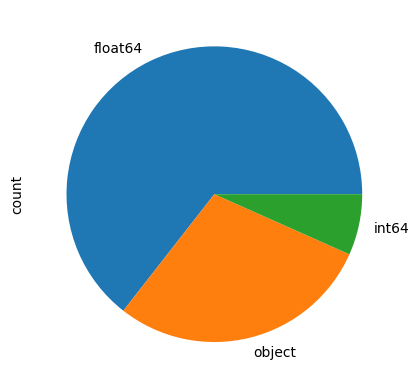

In [ ]:
dfb.dtypes.value_counts().plot.pie()
a=dfb.dtypes.value_counts(())
a

# On peut aussi affecter avec la fonction map() qui vient avec le package numpy

In [ ]:
dfb.isnull()

In [ ]:
dfb = dfb.fillna(dfb.mean())
y=dfb["P (kg/t)"] #la variable cible à prédire ("Apprentissage supervisé")
x=dfb.drop("P (kg/t)", axis=1) #variable explicative permettant de faire la prédiction
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)
scaler = StandardScaler()
num =["C/N","N (kg/t)", "Prix de vente SS (FCFA/kg)", "K (kg/t)", "C (kg/t)","PRO", "Prix de vente SP (FCFA/kg)", "type", "Secteur d'activité", "QSP (t ou kL)", "QSS (t ou kL)", "Destination 1", "Destination 2", "Destination 3", "Destination 4", "Utilisation 1", "Utilisation 2", "Utilisation 3", "QA (t ou kL)", "Localisation (V1)", "Localisation (V2)"]
x_train[num] = scaler.fit_transform(x_train[num])
x_test[num] = scaler.transform(x_test[num])
reg = LinearRegression()
reg.fit(x_train, y_train) 
y_pred_reg = reg.predict(x_test)
# entre 0 et 1
print("Score :", r2_score(y_test, y_pred_reg))
print("\n")
print("Prédictions de y_test :", y_pred_reg)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_reg)
line = mlines.Line2D([0,1],[0,1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.title("Vrais rapports VS rapports prédits")
plt.show()


# Cela va permettre d'afficher les différents tests effectués

In [ ]:
# n est le nombre d'essais qu'on souhaite faire
n ={}
dfb = {f"Test{i}": np.random.randn(100) for i in range(n)}

In [ ]:
# définition de la fonction f
def f (x):
    return x**2 + 3*x


In [ ]:
# Utilisation de la fonction de minimisation
# p est la valeur de départ
def optimize ():
    optimize.minimize (f , x0 =p)

# Pour Korhogo

In [ ]:
dfk = df_korhogo
dfk